# Merging diffuse scattering with *mdx2*

In this tutorial, we will:

- Merge unscaled intensities for a quick look at reciprocal space
- Fit a scaling model
- Merge scaled intensities for a better quality map

Requirements:
- `geometry.nxs` from the *mdx2* geometry tutorial
- `corrected.nxs` from the *mdx2* integration tutorial

<div class="alert alert-block alert-warning">
<b>NOTE: This tutorial assumes you have already procesed the full dataset (50 degrees).</b> If you've only processed the first 6 degrees so far (started from results_1_60.expt), you can use a pre-processed corrected.nxs (attached to this release on GitHub), which has the full 50 degrees.
</div>

Imports (run this before you do anything else)

In [6]:
# for loading mdx2 objects in python
from mdx2.utils import loadobj

### Background

#### Merging

The goal of merging is to combine redundant observations (equivalent by e.g. Laue group symmetry). Cubic insulin as 24 Laue group operators, so even with only 50 degrees of data we have good redundancy:

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data


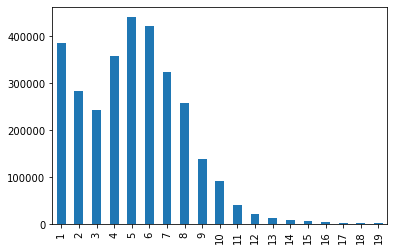

In [7]:
# load table
tab = loadobj('corrected.nxs','hkl_table')

# compute number of times each h,k,l is observed
c = tab.to_frame().groupby(['h','k','l'])['phi'].count().value_counts().sort_index()
c[c>1000].plot.bar();

#### Scaling

In order to merge a high quality map, it's usually necessary to correct for non-ideal aspects of the experiment by scaling.

Scaling is important in Bragg data reduction also. Programs like *aimless*, *xscale*, and *dials.scale* are commonly used, and they have similar scaling models.

One key difference between diffuse and Bragg data is that Bragg intensities have an internal background reference (the intensity near the peak), so separate background measurements are not required. In diffuse scattering, the experimental background subtraction is not always perfect. So a scaling model for diffuse scattering might also include a correction to the background.

We previously implemented a scaling model for diffuse scattering in *mdx-lib* that includes four terms:

- $a =$ absorption correction (a function of phi, x, and y) 
- $b =$ overall scale (a function of phi) 
- $c =$ isotropic background (a function of phi and s) 
- $d =$ detector chip gain (a function of x and y)

The model is refined using regularization to ensure that the correction factors vary smoothly (e.g. as a function of phi).

In *mdx2*, we have only implemented the $b$ term so far. That turns out to be good enough for the insulin dataset, so we'll use it here. The procedure for refining the full scaling model is similar, and will be available in future releases.


## 1) Quick slice

### *mdx2.merge*

This command lets us merge all redundant observations to produce a table of intensities in the asymmetric unit.

In [8]:
!mdx2.merge --help

usage: mdx2.merge [-h] [--scale SCALE] [--outfile OUTFILE] hkl

Merge corrected intensities using a scaling model

positional arguments:
  hkl                NeXus file with hkl_table

optional arguments:
  -h, --help         show this help message and exit
  --scale SCALE      NeXus file with scaling_model (default: None)
  --outfile OUTFILE  name of the output NeXus file (default: merged.nxs)


#### Parameter choice

The scaling model is optional. Since we haven't scaled the data let, let's just run it on the unscaled data and see what it looks like.

In [13]:
!mdx2.merge corrected.nxs --outfile merged_not_scaled.nxs

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
Merging
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged_not_scaled.nxs
done!


### *mdx2.map*

The result from merging is just another table of values. To visualize this table we'll generate a slice through reciprocal space by symmetry expansion and plot it using *nexpy*.

The *mdx.map* command can make slices for plotting (it can also generate a 3D volume - more on this later).

In [14]:
!mdx2.map --help

usage: mdx2.map [-h] [--symmetry TF] [--limits H1 H2 K1 K2 L1 L2]
                [--signal SIGNAL] [--outfile OUTFILE]
                geom hkl

Create a map from data in an hkl table

positional arguments:
  geom                  NeXus file with symmetry and crystal
  hkl                   NeXus file with hkl_table

optional arguments:
  -h, --help            show this help message and exit
  --symmetry TF         apply symmetry operators? (default: True)
  --limits H1 H2 K1 K2 L1 L2
                        region to map (default: [0, 10, 0, 10, 0, 10])
  --signal SIGNAL       column in hkl_table to map (default: intensity)
  --outfile OUTFILE     name of the output NeXus file (default: map.nxs)


#### Parameter choice

We need to set the limits of the map. We'll look at a slice with $l=0$.

In [15]:
!mdx2.map geometry.nxs merged_not_scaled.nxs --limits -50 50 -50 50 0 0 --outfile slice_not_scaled.nxs

Reading hkl_table from merged_not_scaled.nxs
  importing as HKLTable from mdx2.data
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
map region:
  h from -50.0 to 50.0 (401 grid points)
  k from -50.0 to 50.0 (401 grid points)
  l from 0.0 to 0.0 (1 grid points)
generating Miller index array
mapping Miller indices to asymmetric unit
looking up intensity in data table
preparing output array
Exporting <class 'mdx2.geometry.GridData'> to nexus object
  writing intensity to slice_not_scaled.nxs
done!


### Visualization in *nexpy*

Open `slice_not_scaled.nxs` in *nexpy*. Adjust the sliders in the "signal" tab to clearly see the background.

<div class="alert alert-block alert-info">
    <b>Question:</b> Can you see any artifacts in the map?
</div>

## 2) Scaling

### *mdx2.scale*

In [35]:
!mdx2.scale --help

usage: mdx2.scale [-h] [--smoothness SMOOTHNESS] [--phi_increment DEGREES]
                  [--iter ITER] [--outfile OUTFILE]
                  hkl

Fit scaling model to unmerged corrected intensities

positional arguments:
  hkl                   NeXus file with hkl_table

optional arguments:
  -h, --help            show this help message and exit
  --smoothness SMOOTHNESS
                        amount to multiply the regularization parameter
                        (default: 1)
  --phi_increment DEGREES
                        spacing of phi control points in degrees (default: 1)
  --iter ITER           number of iterations (default: 5)
  --outfile OUTFILE     name of the output NeXus file (default: scales.nxs)


#### Parameter choice

The defaults are fine to get started.

In [45]:
!mdx2.scale corrected.nxs --smoothness 1

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
initializing scaling model with 51 samples
iteration 1 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 1.3362474224487717
iteration 2 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 1.0108451187022505
iteration 3 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 0.9876241832268707
iteration 4 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 0.9859305872556283
iteration 5 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 0.9858042534411342
finished refining
Exporting <class 'mdx2.scaling.ScalingModel'> to nexus object
  writing scaling_model to scales.nxs
done!


### Results

You should see $\chi^2$ (`x2`) drop with each iteration, until it settles down to ~1 by iteration 5.

The scale model parameters are saved in a NeXus file. You can plot them by opening the file in *nexpy* and double-clicking. For convenience I'll plot them in the notebook.

Reading scaling_model from scales.nxs
  importing as ScalingModel from mdx2.scaling


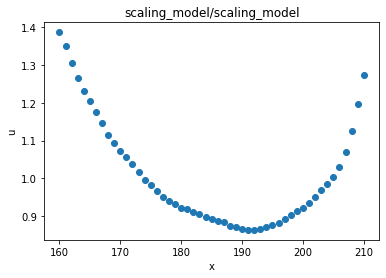

In [46]:
Model = loadobj('scales.nxs','scaling_model')
Model.to_nexus().plot()

## 3) Merging scaled data

Now that we have a scaling model, we can merge and then generate slices and volumes.

In [39]:
!mdx2.merge corrected.nxs --scale scales.nxs

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
Reading scaling_model from scales.nxs
  importing as ScalingModel from mdx2.scaling
Calculating scales
Merging
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged.nxs
done!


### 2D slice

In [41]:
!mdx2.map geometry.nxs merged.nxs --limits -50 50 -50 50 0 0 --outfile slice.nxs

Reading hkl_table from merged.nxs
  importing as HKLTable from mdx2.data
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
map region:
  h from -50.0 to 50.0 (401 grid points)
  k from -50.0 to 50.0 (401 grid points)
  l from 0.0 to 0.0 (1 grid points)
generating Miller index array
mapping Miller indices to asymmetric unit
looking up intensity in data table
preparing output array
Exporting <class 'mdx2.geometry.GridData'> to nexus object
  writing intensity to slice.nxs
done!


#### Visualization in *nexpy*

Open `slice.nxs` in *nexpy* and adjust the sliders in the signal tab to make the background scattering variations clear.

<div class="alert alert-block alert-info">
    <b>Questions:</b> Has scaling reduced the artifacts in the map? What artifacts remain?
</div>

The result should look something like this:

![INSULIN](resources/insulin_slice.png)

### 3D map

We can also use *mdx2.map* to generate a 3D volume rather than a slice. This can be a bit resource intensive. So for the totorial we'll reconstruct one octant of reciprocal space (which is the same as the other seven by symmetry).

In [42]:
# map of positive octant (h>=0, k>=0, l>=0)
!mdx2.map geometry.nxs merged.nxs --limits -0 50 0 50 0 50 --outfile map.nxs

Reading hkl_table from merged.nxs
  importing as HKLTable from mdx2.data
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
map region:
  h from 0.0 to 50.0 (201 grid points)
  k from 0.0 to 50.0 (201 grid points)
  l from 0.0 to 50.0 (201 grid points)
generating Miller index array
mapping Miller indices to asymmetric unit
looking up intensity in data table
preparing output array
Exporting <class 'mdx2.geometry.GridData'> to nexus object
  writing intensity to map.nxs
done!


#### Visualization in *nexpy*

Open `map.nxs` in *nexpy*. Scroll through z-slices. It helps to unselect "autoscale" in the z tab so that intensity scale is fixed, and then set adjust it in the "signal" tab.

Spend some time looking through the map.

<div class="alert alert-block alert-info">
    <b>Questions:</b> What sorts of diffuse scattering features can you find? How might you test whether a feature is real or an artifact of processing? How might you further process the data?
</div >

## Next steps

In the workflow we developed with *mdx-lib*, the next steps are absolute intensity scaling and 3D-$\Delta$PDF estimation. They have not been implemented yet in *mdx2*, so this is as far as we'll go in this tutorial. I encourage you to read more about them in our 2020 Nature Communications paper, and to try *mdx-lib* if you are interested.

The final tutorial contains examples of how *mdx2* can be used in a python environment for crystallographic computing. It is intended for someone familiar with python. It complements the first 5 tutorials, but is optional.

Alternatively, you might consider going back through the tutorials to explore different parameter choices. For example, what happens to the scaling model if you set "--smoothness 0"?